# Winter Water

Quick script to look up the characteristics of the permanent thermocline in the Ross Sea region. The interest here is that above the permanent thermocline, there is a layer of cold water that is part of the mixed layer in winter, but is capped by a fresher, warmer layer in summer. The question is what is the mechanism for  restratifying or diluting this **Winter Water** layer over the summer months.

*AH - 29 March 2019*

In [49]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import IPython.display
import pandas as pd
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
from dask.distributed import Client, progress

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

In [2]:
figdir = ''
def savefigure(fname):
    plt.savefig(os.path.join(figdir, fname+'.png'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    #plt.savefig(os.path.join(figdir, fname+'.pdf'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    return

In [3]:
## To implement, use:
## dask-scheduler
## dask-worker tcp://10.0.64.5:8786 --memory-limit 4e9 --nprocs 6 --nthreads 1 --local-directory /local/g40/amh157
client = Client('tcp://10.0.64.5:8786', local_dir='/local/g40/amh157')
client

<Client: scheduler='tcp://10.0.64.5:8786' processes=6 cores=6>

In [4]:
KELVIN_TO_CELSIUS = -273.15

**Load and subsample the temperature and salinity data:**
* Load 5 years (30 files) of ACCESS-OM2-01 data (2013-2017).
* Extract a slice at 170°W, from 80°S-45°S.
* Group into months and average over the 5 years

In [98]:
%%time
temp = cc.get_nc_variable('01deg_jra55v13_iaf','ocean.nc','temp',chunks={'xt_ocean':5},
                          n=-30,time_units='days since 0001-01-01', offset=None) + KELVIN_TO_CELSIUS
temp = temp.sel(xt_ocean=-170,method='nearest').sel(yt_ocean=slice(-80,-45)).groupby('time.month').mean('time').load()

Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


In [109]:
%%time
salt = cc.get_nc_variable('01deg_jra55v13_iaf','ocean.nc','salt',chunks={'xt_ocean':5},
                          n=-30,time_units='days since 0001-01-01', offset=None)
salt = salt.sel(xt_ocean=-170,method='nearest').sel(yt_ocean=slice(-80,-45)).groupby('time.month').mean('time').load()

Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
CPU times: user 1min 6s, sys: 15.5 s, total: 1min 21s
Wall time: 3min 11s


## First, plot a transect of T-S climatology

Text(0.5, 0, '°C')

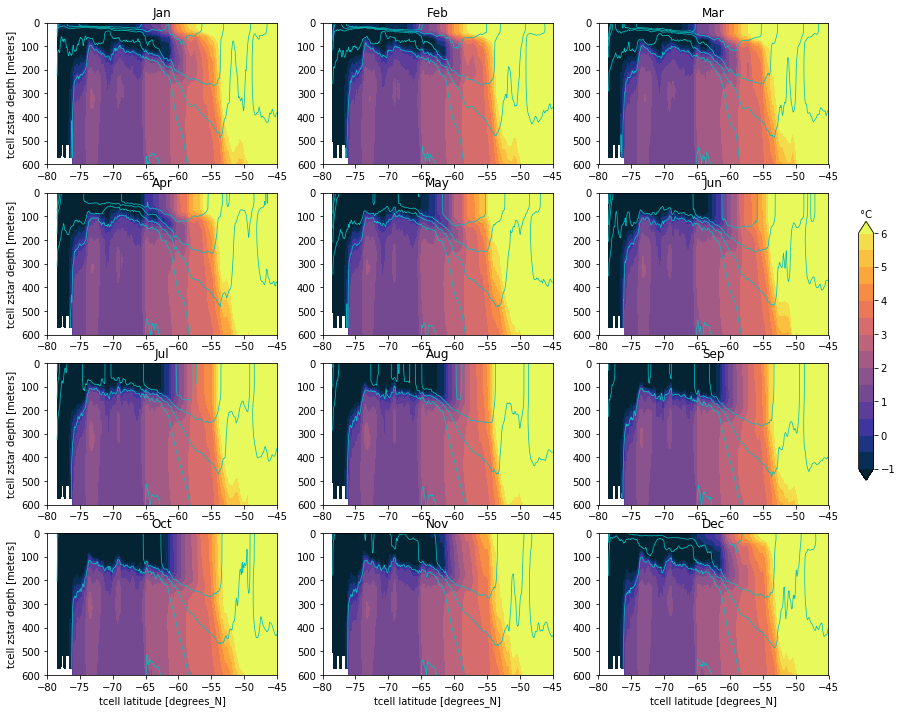

In [143]:
plt.figure(figsize=(14,12))
for ii in range(12):
    plt.subplot(4,3,ii+1)
    p1=temp.isel(month=ii).plot.contourf(yincrease=False,levels=np.linspace(-1, 6,15),cmap=cm.cm.thermal,add_colorbar=False)
    salt.isel(month=ii).plot.contour(yincrease=False,colors='c',linewidths=0.75,levels=np.linspace(33.6, 35.2,8))
    plt.ylim([600,0])
    plt.title(pd.to_datetime(ii+1,format='%m').strftime('%b'))
    if ii<9:
        plt.xlabel('')
    if np.mod(ii,3)>0:
        plt.ylabel('')

ax1 = plt.axes([0.93,0.35, 0.015, 0.3])
cb = plt.colorbar(p1,cax=ax1,orientation='vertical')
ax1.xaxis.set_label_position("top")
cb.ax.set_xlabel('°C')

This plot shows the development of the winter water layer at this longitude. **It is shallower and smaller than I expected, but maybe it's an OK representation of this area??**


## Here are profiles of T-S at 61°S

Text(0.5, 0, 'Salinity (g/kg)')

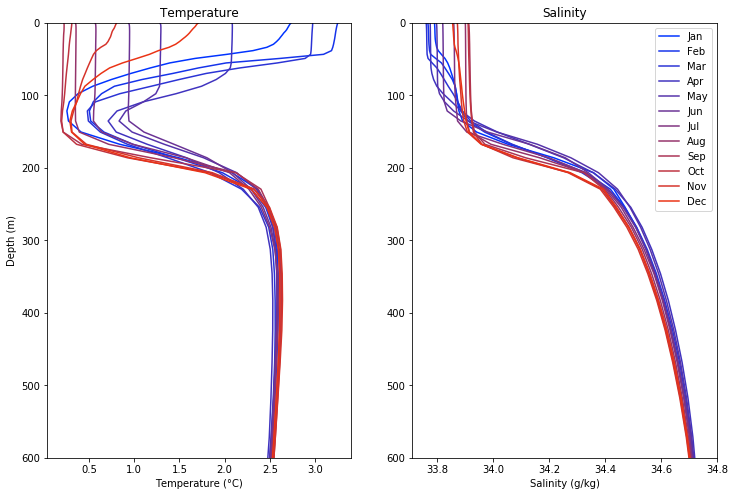

In [152]:
plt.figure(figsize=(12,8))
plt.subplot(121)
for ii in range(12):
    plt.plot(temp.isel(month=ii).sel(yt_ocean=-61,method='nearest'),temp.st_ocean,color=(ii/12,0.2,(1-ii/12)))

plt.gca().invert_yaxis()
plt.ylim([600,0])
plt.title('Temperature')
plt.ylabel('Depth (m)')
plt.xlabel('Temperature (°C)')

plt.subplot(122)
for ii in range(12):
    plt.plot(salt.isel(month=ii).sel(yt_ocean=-61,method='nearest'),salt.st_ocean,color=(ii/12,0.2,(1-ii/12)),
             label=pd.to_datetime(ii+1,format='%m').strftime('%b'))

plt.legend()
plt.gca().invert_yaxis()
plt.ylim([600,0])
plt.title('Salinity')
plt.xlabel('Salinity (g/kg)')

Shows the formation and decay of the winter water alyer, and how it correspends to the mixed layer. **This part looks pretty realistic to me.**

## And here is the seasonal cycle at 10m, 130m and 300m depth

Text(0.5, 1.0, 'Salinity')

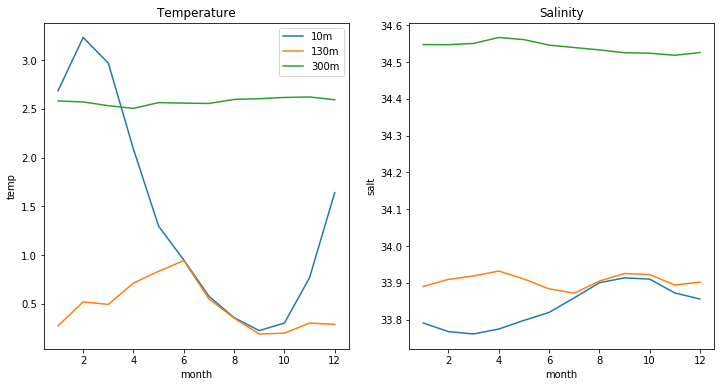

In [160]:
plt.figure(figsize=(12,6))
plt.subplot(121)
temp.sel(st_ocean=10,method='nearest').sel(yt_ocean=-61,method='nearest').plot(label='10m')
temp.sel(st_ocean=130,method='nearest').sel(yt_ocean=-61,method='nearest').plot(label='130m')
temp.sel(st_ocean=300,method='nearest').sel(yt_ocean=-61,method='nearest').plot(label='300m')
plt.legend()
plt.title('Temperature')

plt.subplot(122)
salt.sel(st_ocean=10,method='nearest').sel(yt_ocean=-61,method='nearest').plot(label='10m')
salt.sel(st_ocean=130,method='nearest').sel(yt_ocean=-61,method='nearest').plot(label='130m')
salt.sel(st_ocean=300,method='nearest').sel(yt_ocean=-61,method='nearest').plot(label='300m')
plt.title('Salinity')

This shows the evolution at 3 depths, with gradual warming at 130 m in teh summer months, and cooling in the winter. Salinity profile has a double peak at 130m.

## Conclusions
**If these diagnostics are vaguely realistic** then perhaps the model will give us information on the processes that eat away at teh winter water layer during the summer months ...